In [1]:
#OBJECTIEVES ->

#1. SOLVE DATA IMBALANCE
#2. DRAW FANCY GRAPHS
#3. USE ONECYCLE_LR, DIFF_LR
#4. MORE AUGMENTATION
#5. VISION TRANSFORMER to classift disaster or non disaster

In [2]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import timm
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#will convert to GPU when required

Using device: cuda


## Class Names

In [5]:
class_names = {
    0: 'Water_Disaster',
    1: 'Non_Damaged_Wildlife_Forest',
    2: 'Non_Damaged_sea',
    3: 'Non_Damaged_Buildings_Street',
    4: 'Non_Damaged_human',
    5: 'Damaged_Infrastructure',
    6: 'Earthquake',
    7: 'Human_Damage',
    8: 'Urban_Fire',
    9: 'Wild_Fire',
    10: 'Land_Slide',
    11: 'Drought',
}

num_classes = len(class_names)

# GLOBAL VARS #

In [6]:
#Global Vars

train_ratio, val_ratio= 0.7, 0.3
batch_size = 8 #CHAGNE LATER
num_epochs = 5 #CHANGE LATER
max_images = 100000000

## Converting Kaggle Dataset to .csv

In [7]:

if os.path.exists("/kaggle/working/disaster_image_dataset.csv"):
    dataset_loaded_already = True
else:
    dataset_loaded_already = False

def get_image_paths_and_labels(root_dir):
    classes = []
    image_paths = []
    class_to_idx = {}
    current_class_idx = 0

    count = 0
    
    for root, subdirs, files in os.walk(root_dir):
        if not subdirs:
            class_name = os.path.relpath(root, root_dir)
            classes.append(class_name)
            class_to_idx[class_name] = current_class_idx
            current_class_idx += 1
    
            if count >= max_images:
                break
            
            # Get all image files in this class
            for file in files:
                if file.endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append((os.path.join(root, file), class_to_idx[class_name]))
                    count += 1

    #Adding a Fake Data Class so that the vision transformer can return 1 to that as [0,0,0,0,0,0,0,0,0,0,0,0,1]
    #class_to_idx["Fake"] = current_class_idx
    
    return image_paths, class_to_idx

root_dir = '/kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)'

if not dataset_loaded_already:
    image_paths_and_labels, class_to_idx_dict = get_image_paths_and_labels(root_dir)
    num_of_classes = len(class_to_idx_dict)
    
    #Reversing the dictionary
    idx_to_class = {}
    
    for key, value in class_to_idx_dict.items():
        idx_to_class[value] = key
    
    disaster_image_dataset_dict = {
        "Image_Paths": [t[0] for t in image_paths_and_labels],
        "Labels": [t[1] for t in image_paths_and_labels]
    }
    
    #Dataframe
    disaster_image_dataset_df = pd.DataFrame(disaster_image_dataset_dict)
    
    #CSV file
    disaster_image_dataset_df.to_csv("disaster_image_dataset.csv", index=False)

    print(f"DataSaved as 'disaster_image_dataset.csv' ")

DataSaved as 'disaster_image_dataset.csv' 


In [8]:
idx_to_class

{0: 'Water_Disaster',
 1: 'Non_Damage/Non_Damage_Wildlife_Forest',
 2: 'Non_Damage/sea',
 3: 'Non_Damage/Non_Damage_Buildings_Street',
 4: 'Non_Damage/human',
 5: 'Damaged_Infrastructure/Infrastructure',
 6: 'Damaged_Infrastructure/Earthquake',
 7: 'Human_Damage',
 8: 'Fire_Disaster/Urban_Fire',
 9: 'Fire_Disaster/Wild_Fire',
 10: 'Land_Disaster/Land_Slide',
 11: 'Land_Disaster/Drought'}

In [9]:
disaster_dataset = pd.read_csv('/kaggle/input/disaster-images-data/disaster_image_dataset (2).csv')

## Dataset

In [10]:
disaster_dataset

,Image_Paths,Labels
0,/kaggle/input/disaster-images-dataset/Comprehe...,0
1,/kaggle/input/disaster-images-dataset/Comprehe...,0
2,/kaggle/input/disaster-images-dataset/Comprehe...,0
3,/kaggle/input/disaster-images-dataset/Comprehe...,0
4,/kaggle/input/disaster-images-dataset/Comprehe...,0
...,...,...
13552,/kaggle/input/disaster-images-dataset/Comprehe...,11
13553,/kaggle/input/disaster-images-dataset/Comprehe...,11
13554,/kaggle/input/disaster-images-dataset/Comprehe...,11
13555,/kaggle/input/disaster-images-dataset/Comprehe...,11


# EDA #


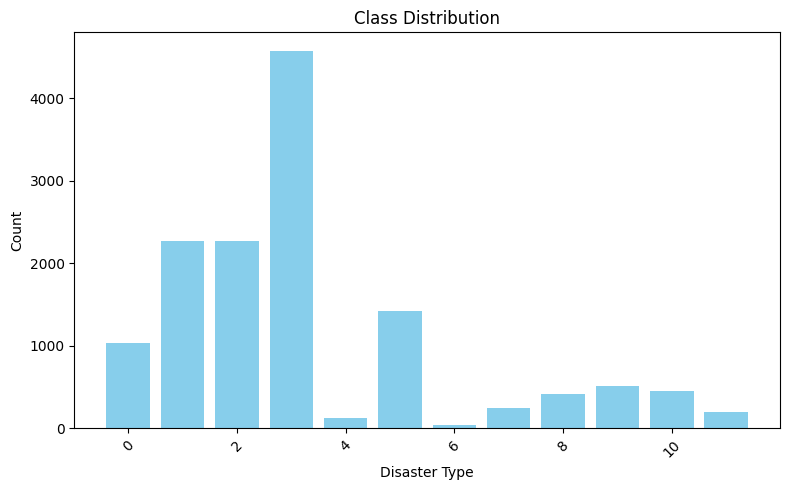

In [11]:
import matplotlib.pyplot as plt

# Count values
counts = disaster_dataset['Labels'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(counts.index, counts.values, color='skyblue')

plt.title("Class Distribution")
plt.xlabel("Disaster Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Inference

#### I will have to use some techniques to tackle this class imbalance

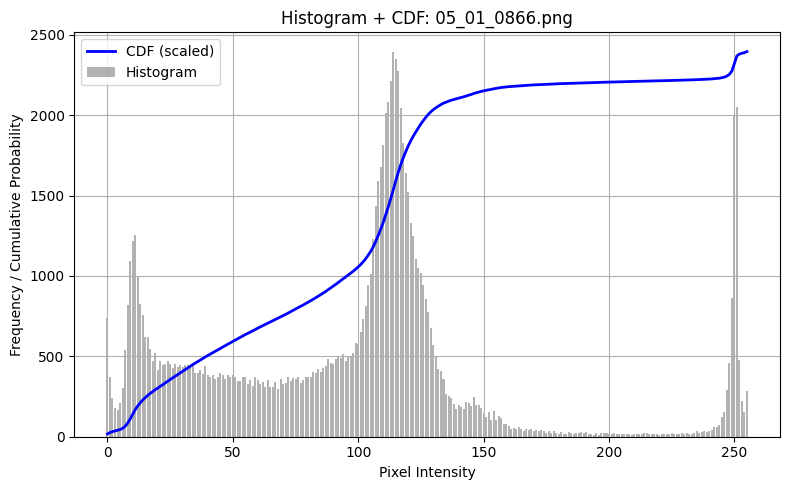

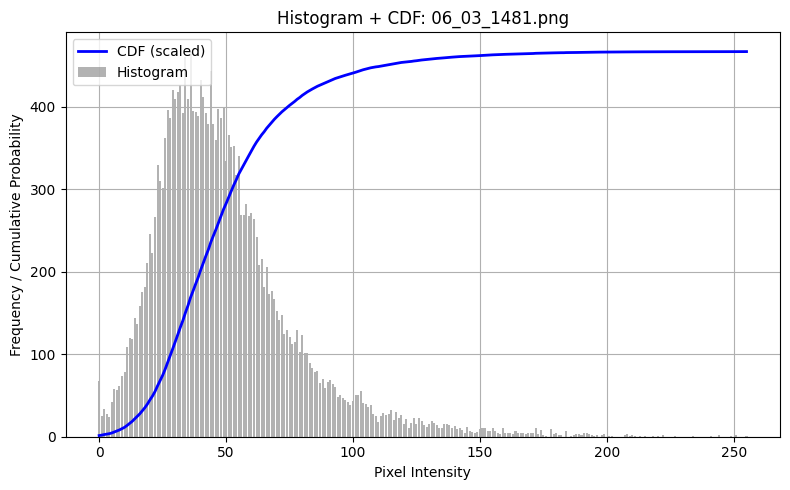

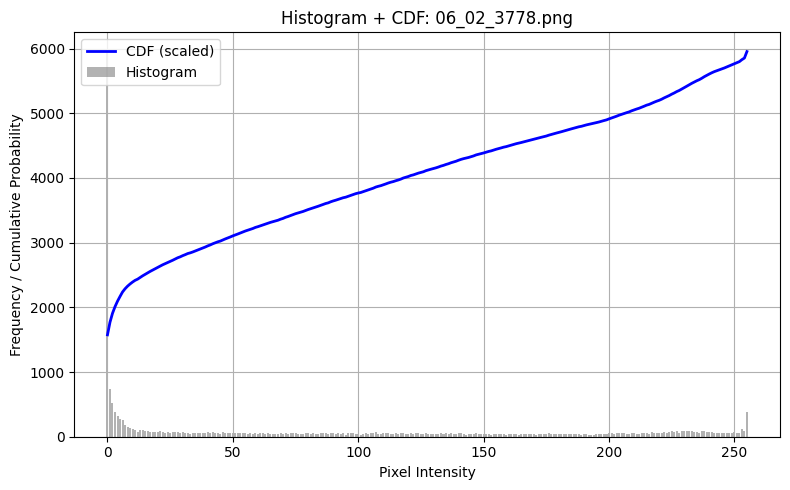

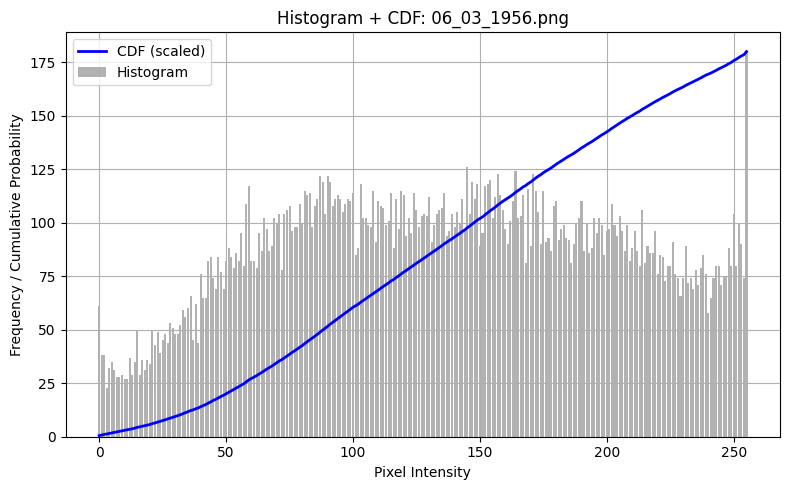

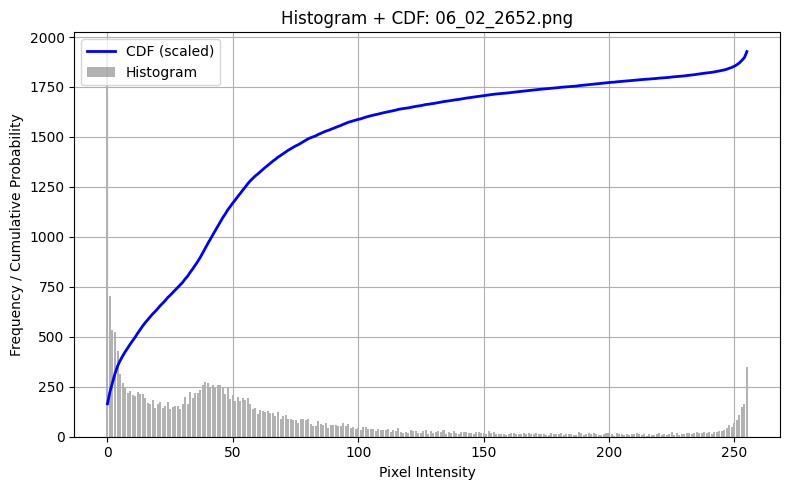

In [12]:
import cv2
import matplotlib.pyplot as plt
import random
import os
import numpy as np

def plot_histogram_with_cdf(image_paths, sample_size=5):
    sample_paths = random.sample(image_paths, min(sample_size, len(image_paths)))

    for path in sample_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        # Compute histogram
        hist = cv2.calcHist([img], [0], None, [256], [0, 256]).ravel()
        hist_norm = hist / hist.sum()  # Normalize
        cdf = hist_norm.cumsum()

        plt.figure(figsize=(8, 5))

        plt.title(f'Histogram + CDF: {os.path.basename(path)}')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency / Cumulative Probability')

        # Plot histogram (bar chart)
        plt.bar(range(256), hist, color='gray', alpha=0.6, label='Histogram')

        # Plot CDF (line)
        plt.plot(cdf * hist.max(), color='blue', linewidth=2, label='CDF (scaled)')  # scale CDF to match histogram scale

        plt.legend(loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example usage
plot_histogram_with_cdf(disaster_dataset["Image_Paths"].to_list())

# Inference

#### We see in Grayscale that some images are too dark and some are bright and there is not uniformness so we will use CLAHE. 
#### What is CLAHE? -> Contrast limiting adaptige histo equalization -> better histo equalization cmopared to global histo equalization as differnet parts of images have differnt contrast.
#### this CLAHE  will be used in Dataset class

## Custom Image Dataset

In [13]:
from PIL import Image

class Custom_Image_Dataset(Dataset):
    
    def __init__(self, dis_df, apply_clahe=True):
        self.image_paths = dis_df["Image_Paths"]
        self.labels = dis_df["Labels"]
        self.apply_clahe = apply_clahe

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]

       # Load as OpenCV (BGR)
        img = cv2.imread(path)
        if img is None:
            print(f"[Warning] Unable to read image at: {path}. Skipping...")
            return self.__getitem__((idx + 1) % len(self.image_paths))

        if self.apply_clahe:
            # Convert to LAB and apply CLAHE to L-channel
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            cl = clahe.apply(l)
            lab = cv2.merge((cl, a, b))
            img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)  # Back to RGB
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = Image.fromarray(img) #converts to tensor
        img = self.transform(img)
        return img, label

In [14]:
dataset_length = len(disaster_dataset)
train_size = int(train_ratio * dataset_length)
val_size = dataset_length - train_size
train_dataset, val_dataset= random_split(disaster_dataset, [train_size, val_size])

In [15]:
Disaster_Dataset = Custom_Image_Dataset(disaster_dataset)

# Custom Model

In [16]:
model = timm.create_model('efficientnet_lite0', pretrained=True, num_classes=num_classes)
model.to(device)

model.safetensors:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequent

In [17]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## Training

In [20]:
from sklearn.model_selection import StratifiedKFold

# Assuming these are already defined:
# dataset: your custom Dataset object
# labels_array: list or array of integer class labels
# model, optimizer, criterion, num_epochs, batch_size, device

def train_with_val_graphs(dataset, idx_to_class):


    
    num_classes = len(idx_to_class)
    print(f"Number of Classes: {num_classes}")
    
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    labels_array = dataset.labels
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels_array)), labels_array)):
        print(f"\n===== Fold {fold + 1} =====")
        print(f"Train size: {len(train_idx)}, Val size: {len(val_idx)}")
    
        # Create DataLoaders for current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
    
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)
            
        start_time = time.time()
    
        #lists
        train_losses, val_losses, train_accuracies, val_accuracies, = [], [], [], []
        
        train_recalls = torch.zeros((num_epochs, num_classes), dtype=torch.float32, device=device)
        val_recalls = torch.zeros((num_epochs, num_classes), dtype=torch.float32, device=device)
        
        #val_recalls
        
        train_precisions = torch.zeros((num_epochs, num_classes), dtype=torch.float32, device=device)
        val_precisions = torch.zeros((num_epochs, num_classes), dtype=torch.float32, device=device)
        
        #val_precisions

        train_f1s = torch.zeros((num_epochs, num_classes), dtype=torch.float32, device=device)
        val_f1s = torch.zeros((num_epochs, num_classes), dtype=torch.float32, device=device)
    
    
        for epoch in range(num_epochs):
    
            print(f'Started epoch: {epoch}, using device:{device} ') 
            
            model.train()
    
            running_loss = 0.0
            running_corrects = 0.0
    
            tps = torch.zeros(num_classes, dtype=torch.float32, device=device)
            fns = torch.zeros(num_classes, dtype=torch.float32, device=device)
            fps = torch.zeros(num_classes, dtype=torch.float32, device=device)

            #for validation
            v_tps = torch.zeros(num_classes, dtype=torch.float32, device=device)
            v_fns = torch.zeros(num_classes, dtype=torch.float32, device=device)
            v_fps = torch.zeros(num_classes, dtype=torch.float32, device=device)
    
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                #to zero out the gradients
                optimizer.zero_grad() 
    
                #forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
    
                #Update the params
                optimizer.step()
                
                _, preds = torch.max(outputs, 1)
                preds = preds.to(device)
                    
                #Scales up the loss
                running_loss += loss.item() * inputs.size(0)
                
                #preds is like 0,1,2... and laebls is also 0,1,2
                running_corrects += torch.sum(preds == labels)
    
                #For Recall and Precision
                for c in range(num_classes):
                    tps[c] += torch.sum((labels==c) & (preds == c))
                    fns[c] += torch.sum((labels==c) & (preds != c))
                    fps[c] += torch.sum((labels!=c) & (preds == c))
    
            eps = 1e-6
            
            def recall(true_pos, false_neg):
                return (true_pos/((true_pos + false_neg) + eps))
    
            def precision(true_pos, false_pos):
                return (true_pos/((true_pos + false_pos) + eps))

            def f1_score(recalls, precisions):
                return(2 * recalls * precisions /(recalls + precisions + eps))
            
            #Calculate Recall and Precision for each class ->
            for c in range(num_classes):
                train_recalls[epoch][c] = recall(tps[c], fns[c])
                train_precisions[epoch][c] = precision(tps[c], fps[c])
                train_f1s[epoch][c] = f1_score(train_recalls[epoch][c], train_precisions[epoch][c])
            
            
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset)
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
    
            print('Entering Validation Phase....')
            
            #---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
             # Validation phase
            model.eval()
            running_loss = 0.0
            running_corrects = 0
    
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
    
                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    #For Recall and Precision
                    for c in range(num_classes):
                        v_tps[c] += torch.sum((labels==c) & (preds == c))
                        v_fns[c] += torch.sum((labels==c) & (preds != c))
                        v_fps[c] += torch.sum((labels!=c) & (preds == c))
    
            epoch_loss = running_loss / len(val_loader.dataset)
            epoch_acc = running_corrects.double() / len(val_loader.dataset)
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

            #Calculate Recall and Precision for each class ->
            for c in range(num_classes):
                val_recalls[epoch][c] = recall(v_tps[c], v_fns[c])
                val_precisions[epoch][c] = precision(v_tps[c], v_fps[c])
                val_f1s[epoch][c] = f1_score(val_recalls[epoch][c], val_precisions[epoch][c])
            
    
    
            print('-' * 50)
            print(f'Epoch {epoch+1}/{num_epochs}, '
                  f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')
    
            for c in range(num_classes):
                print(f'For Class: {c}, Train Recall: {train_recalls[epoch][c]:.4f}, Train Precision: {train_precisions[epoch][c]:.4f}, Train F1 Score is: {train_f1s[epoch][c]}')
                print(f'For Class: {c}, Val Recall: {val_recalls[epoch][c]:.4f}, Val Precision: {val_precisions[epoch][c]:.4f}, Val F1 Score is: {val_f1s[epoch][c]}')
            
            print('-' * 50)
        
        # Plot training & validation loss and accuracy
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.legend()
        plt.title('Loss')
    
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')
    
        plt.show()
    
        end_time = time.time()
    
        print(f"Execution took: {end_time - start_time:.2f} secs")


Number of Classes: 12

===== Fold 1 =====
Train size: 10845, Val size: 2712
Started epoch: 0, using device:cuda 
[Warning] Unable to read image at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png. Skipping...


Premature end of JPEG file


Entering Validation Phase....
--------------------------------------------------
Epoch 1/5, Train Loss: 0.2746, Train Accuracy: 0.9113, Val Loss: 0.2195, Val Accuracy: 0.9288
For Class: 0, Train Recall: 0.8297, Train Precision: 0.8188, Train F1 Score is: 0.8242346048355103
For Class: 0, Val Recall: 0.8213, Val Precision: 0.9043, Val F1 Score is: 0.8607590794563293
For Class: 1, Train Recall: 0.9615, Train Precision: 0.9673, Train F1 Score is: 0.9643740057945251
For Class: 1, Val Recall: 0.9846, Val Precision: 0.9825, Val F1 Score is: 0.9835340976715088
For Class: 2, Train Recall: 0.9527, Train Precision: 0.9538, Train F1 Score is: 0.9532706141471863
For Class: 2, Val Recall: 0.9802, Val Precision: 0.9695, Val F1 Score is: 0.974807858467102
For Class: 3, Train Recall: 0.9740, Train Precision: 0.9606, Train F1 Score is: 0.9672772288322449
For Class: 3, Val Recall: 0.9880, Val Precision: 0.9880, Val F1 Score is: 0.9879776835441589
For Class: 4, Train Recall: 0.8854, Train Precision: 0.876

Premature end of JPEG file


[Warning] Unable to read image at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png. Skipping...
Entering Validation Phase....
--------------------------------------------------
Epoch 2/5, Train Loss: 0.1736, Train Accuracy: 0.9426, Val Loss: 0.2319, Val Accuracy: 0.9314
For Class: 0, Train Recall: 0.8816, Train Precision: 0.8913, Train F1 Score is: 0.8864597678184509
For Class: 0, Val Recall: 0.8792, Val Precision: 0.8545, Val F1 Score is: 0.8666661977767944
For Class: 1, Train Recall: 0.9857, Train Precision: 0.9819, Train F1 Score is: 0.9837862849235535
For Class: 1, Val Recall: 0.9802, Val Precision: 0.9911, Val F1 Score is: 0.9856348633766174
For Class: 2, Train Recall: 0.9714, Train Precision: 0.9682, Train F1 Score is: 0.9698294997215271
For Class: 2, Val Recall: 0.9648, Val Precision: 0.9712, Val F1 Score is: 0.9679552912712097
For Class: 3, Train Recall: 0.9839, Train Precision: 0.9809, Train F1 Score is: 0.9823886156082153
For

Premature end of JPEG file


[Warning] Unable to read image at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png. Skipping...
Entering Validation Phase....
--------------------------------------------------
Epoch 3/5, Train Loss: 0.1307, Train Accuracy: 0.9574, Val Loss: 0.2257, Val Accuracy: 0.9336
For Class: 0, Train Recall: 0.9070, Train Precision: 0.9181, Train F1 Score is: 0.9125146269798279
For Class: 0, Val Recall: 0.8164, Val Precision: 0.9235, Val F1 Score is: 0.8666661977767944
For Class: 1, Train Recall: 0.9890, Train Precision: 0.9841, Train F1 Score is: 0.9865416884422302
For Class: 1, Val Recall: 0.9890, Val Precision: 0.9804, Val F1 Score is: 0.9846822619438171
For Class: 2, Train Recall: 0.9835, Train Precision: 0.9776, Train F1 Score is: 0.9805527925491333
For Class: 2, Val Recall: 0.9758, Val Precision: 0.9715, Val F1 Score is: 0.973625898361206
For Class: 3, Train Recall: 0.9874, Train Precision: 0.9850, Train F1 Score is: 0.9862073659896851
For 

Premature end of JPEG file


Entering Validation Phase....
--------------------------------------------------
Epoch 4/5, Train Loss: 0.1049, Train Accuracy: 0.9654, Val Loss: 0.2612, Val Accuracy: 0.9310
For Class: 0, Train Recall: 0.9263, Train Precision: 0.9365, Train F1 Score is: 0.9313899278640747
For Class: 0, Val Recall: 0.8841, Val Precision: 0.8170, Val F1 Score is: 0.849187433719635
For Class: 1, Train Recall: 0.9862, Train Precision: 0.9906, Train F1 Score is: 0.9884101748466492
For Class: 1, Val Recall: 0.9868, Val Precision: 0.9846, Val F1 Score is: 0.9857295155525208
For Class: 2, Train Recall: 0.9857, Train Precision: 0.9793, Train F1 Score is: 0.9824748635292053
For Class: 2, Val Recall: 0.9780, Val Precision: 0.9845, Val F1 Score is: 0.9812150001525879
For Class: 3, Train Recall: 0.9896, Train Precision: 0.9853, Train F1 Score is: 0.9874483346939087
For Class: 3, Val Recall: 0.9923, Val Precision: 0.9913, Val F1 Score is: 0.9918072819709778
For Class: 4, Train Recall: 0.9583, Train Precision: 0.968

Premature end of JPEG file


[Warning] Unable to read image at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png. Skipping...
Entering Validation Phase....
--------------------------------------------------
Epoch 5/5, Train Loss: 0.0838, Train Accuracy: 0.9725, Val Loss: 0.2489, Val Accuracy: 0.9325
For Class: 0, Train Recall: 0.9553, Train Precision: 0.9600, Train F1 Score is: 0.9576266407966614
For Class: 0, Val Recall: 0.8454, Val Precision: 0.8974, Val F1 Score is: 0.8706462979316711
For Class: 1, Train Recall: 0.9873, Train Precision: 0.9890, Train F1 Score is: 0.9881505370140076
For Class: 1, Val Recall: 0.9890, Val Precision: 0.9847, Val F1 Score is: 0.98684161901474
For Class: 2, Train Recall: 0.9819, Train Precision: 0.9835, Train F1 Score is: 0.9826775789260864
For Class: 2, Val Recall: 0.9736, Val Precision: 0.9757, Val F1 Score is: 0.9746411442756653
For Class: 3, Train Recall: 0.9918, Train Precision: 0.9886, Train F1 Score is: 0.990171492099762
For Cl

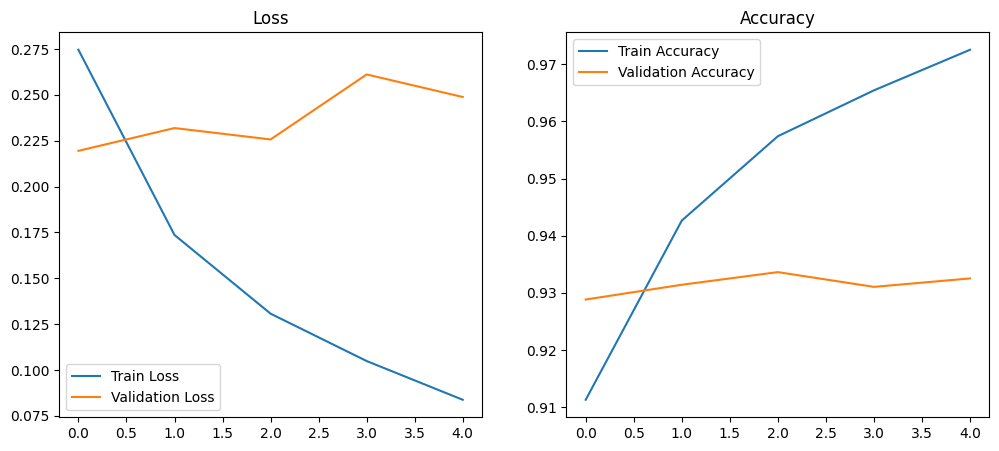

Execution took: 515.30 secs

===== Fold 2 =====
Train size: 10845, Val size: 2712
Started epoch: 0, using device:cuda 
[Warning] Unable to read image at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png. Skipping...


Premature end of JPEG file


Entering Validation Phase....
--------------------------------------------------
Epoch 1/5, Train Loss: 0.1356, Train Accuracy: 0.9592, Val Loss: 0.0405, Val Accuracy: 0.9864
For Class: 0, Train Recall: 0.9130, Train Precision: 0.9242, Train F1 Score is: 0.9185900688171387
For Class: 0, Val Recall: 0.9952, Val Precision: 0.9856, Val F1 Score is: 0.9903841614723206
For Class: 1, Train Recall: 0.9835, Train Precision: 0.9862, Train F1 Score is: 0.9848438501358032
For Class: 1, Val Recall: 1.0000, Val Precision: 0.9913, Val F1 Score is: 0.9956135749816895
For Class: 2, Train Recall: 0.9819, Train Precision: 0.9802, Train F1 Score is: 0.9810487031936646
For Class: 2, Val Recall: 0.9846, Val Precision: 0.9978, Val F1 Score is: 0.9911499619483948
For Class: 3, Train Recall: 0.9918, Train Precision: 0.9867, Train F1 Score is: 0.9892263412475586
For Class: 3, Val Recall: 0.9989, Val Precision: 0.9989, Val F1 Score is: 0.9989066123962402
For Class: 4, Train Recall: 0.9062, Train Precision: 0.93

Premature end of JPEG file


Entering Validation Phase....
--------------------------------------------------
Epoch 2/5, Train Loss: 0.0861, Train Accuracy: 0.9718, Val Loss: 0.0468, Val Accuracy: 0.9867
For Class: 0, Train Recall: 0.9420, Train Precision: 0.9455, Train F1 Score is: 0.9437381029129028
For Class: 0, Val Recall: 0.9903, Val Precision: 0.9716, Val F1 Score is: 0.980860710144043
For Class: 1, Train Recall: 0.9895, Train Precision: 0.9857, Train F1 Score is: 0.9876402616500854
For Class: 1, Val Recall: 0.9978, Val Precision: 0.9978, Val F1 Score is: 0.997796893119812
For Class: 2, Train Recall: 0.9857, Train Precision: 0.9868, Train F1 Score is: 0.9862480759620667
For Class: 2, Val Recall: 0.9956, Val Precision: 0.9978, Val F1 Score is: 0.9966991543769836
For Class: 3, Train Recall: 0.9923, Train Precision: 0.9913, Train F1 Score is: 0.9918005466461182
For Class: 3, Val Recall: 1.0000, Val Precision: 0.9989, Val F1 Score is: 0.9994533658027649
For Class: 4, Train Recall: 0.9583, Train Precision: 0.9485

Premature end of JPEG file


[Warning] Unable to read image at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png. Skipping...
Entering Validation Phase....
--------------------------------------------------
Epoch 3/5, Train Loss: 0.0664, Train Accuracy: 0.9787, Val Loss: 0.0628, Val Accuracy: 0.9805
For Class: 0, Train Recall: 0.9662, Train Precision: 0.9732, Train F1 Score is: 0.9696964621543884
For Class: 0, Val Recall: 0.9758, Val Precision: 0.9352, Val F1 Score is: 0.9550822973251343
For Class: 1, Train Recall: 0.9956, Train Precision: 0.9950, Train F1 Score is: 0.9953227639198303
For Class: 1, Val Recall: 0.9890, Val Precision: 1.0000, Val F1 Score is: 0.9944624304771423
For Class: 2, Train Recall: 0.9940, Train Precision: 0.9923, Train F1 Score is: 0.9931333065032959
For Class: 2, Val Recall: 0.9956, Val Precision: 0.9956, Val F1 Score is: 0.9956039190292358
For Class: 3, Train Recall: 0.9937, Train Precision: 0.9924, Train F1 Score is: 0.9930313229560852
For

Premature end of JPEG file


Entering Validation Phase....
--------------------------------------------------
Epoch 4/5, Train Loss: 0.0548, Train Accuracy: 0.9820, Val Loss: 0.0560, Val Accuracy: 0.9823
For Class: 0, Train Recall: 0.9614, Train Precision: 0.9602, Train F1 Score is: 0.9607719779014587
For Class: 0, Val Recall: 0.9758, Val Precision: 0.9712, Val F1 Score is: 0.9734934568405151
For Class: 1, Train Recall: 0.9945, Train Precision: 0.9945, Train F1 Score is: 0.9944959282875061
For Class: 1, Val Recall: 0.9890, Val Precision: 0.9978, Val F1 Score is: 0.9933623671531677
For Class: 2, Train Recall: 0.9929, Train Precision: 0.9939, Train F1 Score is: 0.993398904800415
For Class: 2, Val Recall: 0.9890, Val Precision: 0.9956, Val F1 Score is: 0.9922817945480347
For Class: 3, Train Recall: 0.9959, Train Precision: 0.9932, Train F1 Score is: 0.9945380687713623
For Class: 3, Val Recall: 0.9989, Val Precision: 0.9967, Val F1 Score is: 0.9978161454200745
For Class: 4, Train Recall: 0.9896, Train Precision: 0.989

Premature end of JPEG file


Entering Validation Phase....
--------------------------------------------------
Epoch 5/5, Train Loss: 0.0572, Train Accuracy: 0.9805, Val Loss: 0.0601, Val Accuracy: 0.9816
For Class: 0, Train Recall: 0.9686, Train Precision: 0.9663, Train F1 Score is: 0.9674301743507385
For Class: 0, Val Recall: 0.9758, Val Precision: 0.9902, Val F1 Score is: 0.9829678535461426
For Class: 1, Train Recall: 0.9901, Train Precision: 0.9912, Train F1 Score is: 0.9906383156776428
For Class: 1, Val Recall: 0.9978, Val Precision: 0.9912, Val F1 Score is: 0.9945110082626343
For Class: 2, Train Recall: 0.9918, Train Precision: 0.9928, Train F1 Score is: 0.9922987222671509
For Class: 2, Val Recall: 0.9912, Val Precision: 0.9956, Val F1 Score is: 0.9933915734291077
For Class: 3, Train Recall: 0.9945, Train Precision: 0.9934, Train F1 Score is: 0.993986964225769
For Class: 3, Val Recall: 0.9978, Val Precision: 0.9978, Val F1 Score is: 0.9978137016296387
For Class: 4, Train Recall: 0.9792, Train Precision: 0.969

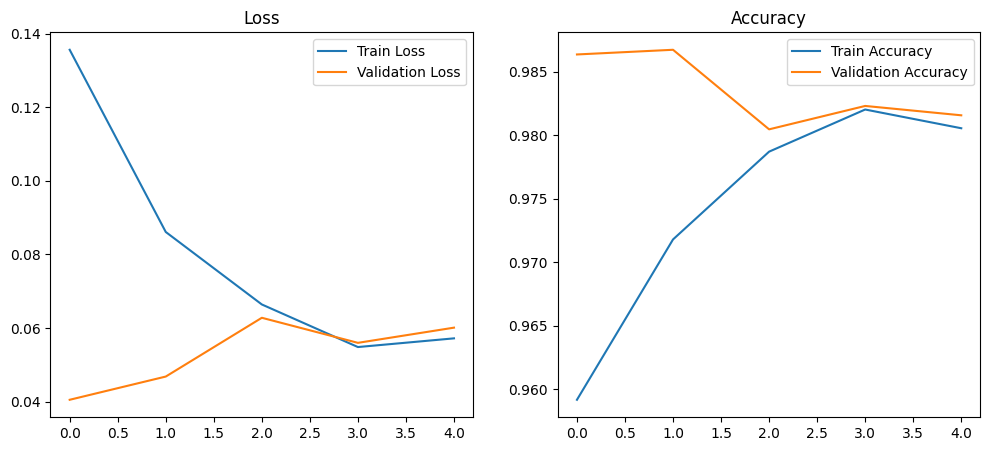

Execution took: 522.18 secs

===== Fold 3 =====
Train size: 10846, Val size: 2711
Started epoch: 0, using device:cuda 


Premature end of JPEG file


[Warning] Unable to read image at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png. Skipping...
Entering Validation Phase....
--------------------------------------------------
Epoch 1/5, Train Loss: 0.0668, Train Accuracy: 0.9789, Val Loss: 0.0250, Val Accuracy: 0.9897
For Class: 0, Train Recall: 0.9601, Train Precision: 0.9578, Train F1 Score is: 0.958986222743988
For Class: 0, Val Recall: 0.9807, Val Precision: 0.9951, Val F1 Score is: 0.987834095954895
For Class: 1, Train Recall: 0.9945, Train Precision: 0.9923, Train F1 Score is: 0.9934024810791016
For Class: 1, Val Recall: 0.9978, Val Precision: 1.0000, Val F1 Score is: 0.9988970160484314
For Class: 2, Train Recall: 0.9907, Train Precision: 0.9885, Train F1 Score is: 0.9895656704902649
For Class: 2, Val Recall: 0.9978, Val Precision: 1.0000, Val F1 Score is: 0.9988994002342224
For Class: 3, Train Recall: 0.9959, Train Precision: 0.9951, Train F1 Score is: 0.9954906702041626
For C

Premature end of JPEG file


[Warning] Unable to read image at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png. Skipping...
Entering Validation Phase....
--------------------------------------------------
Epoch 2/5, Train Loss: 0.0484, Train Accuracy: 0.9830, Val Loss: 0.0350, Val Accuracy: 0.9886
For Class: 0, Train Recall: 0.9601, Train Precision: 0.9683, Train F1 Score is: 0.9642202854156494
For Class: 0, Val Recall: 0.9710, Val Precision: 0.9950, Val F1 Score is: 0.9828845858573914
For Class: 1, Train Recall: 0.9923, Train Precision: 0.9945, Train F1 Score is: 0.9933879971504211
For Class: 1, Val Recall: 0.9890, Val Precision: 1.0000, Val F1 Score is: 0.9944624304771423
For Class: 2, Train Recall: 0.9923, Train Precision: 0.9907, Train F1 Score is: 0.9914854168891907
For Class: 2, Val Recall: 0.9934, Val Precision: 1.0000, Val F1 Score is: 0.9966919422149658
For Class: 3, Train Recall: 0.9948, Train Precision: 0.9934, Train F1 Score is: 0.99412602186203
For C

Premature end of JPEG file


[Warning] Unable to read image at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png. Skipping...
Entering Validation Phase....
--------------------------------------------------
Epoch 3/5, Train Loss: 0.0403, Train Accuracy: 0.9870, Val Loss: 0.0375, Val Accuracy: 0.9867
For Class: 0, Train Recall: 0.9807, Train Precision: 0.9819, Train F1 Score is: 0.9812684059143066
For Class: 0, Val Recall: 0.9952, Val Precision: 0.9717, Val F1 Score is: 0.9832931160926819
For Class: 1, Train Recall: 0.9923, Train Precision: 0.9945, Train F1 Score is: 0.9933879971504211
For Class: 1, Val Recall: 0.9956, Val Precision: 1.0000, Val F1 Score is: 0.9977920055389404
For Class: 2, Train Recall: 0.9967, Train Precision: 0.9956, Train F1 Score is: 0.9961533546447754
For Class: 2, Val Recall: 0.9978, Val Precision: 0.9978, Val F1 Score is: 0.9978017210960388
For Class: 3, Train Recall: 0.9970, Train Precision: 0.9959, Train F1 Score is: 0.9964475631713867
For

Premature end of JPEG file


Entering Validation Phase....
--------------------------------------------------
Epoch 4/5, Train Loss: 0.0446, Train Accuracy: 0.9860, Val Loss: 0.0484, Val Accuracy: 0.9849
For Class: 0, Train Recall: 0.9710, Train Precision: 0.9710, Train F1 Score is: 0.9710140228271484
For Class: 0, Val Recall: 0.9710, Val Precision: 0.9950, Val F1 Score is: 0.9828845858573914
For Class: 1, Train Recall: 0.9945, Train Precision: 0.9950, Train F1 Score is: 0.9947696924209595
For Class: 1, Val Recall: 1.0000, Val Precision: 1.0000, Val F1 Score is: 0.9999995231628418
For Class: 2, Train Recall: 0.9912, Train Precision: 0.9950, Train F1 Score is: 0.9931143522262573
For Class: 2, Val Recall: 0.9978, Val Precision: 1.0000, Val F1 Score is: 0.9988994002342224
For Class: 3, Train Recall: 0.9973, Train Precision: 0.9951, Train F1 Score is: 0.9961764812469482
For Class: 3, Val Recall: 1.0000, Val Precision: 0.9989, Val F1 Score is: 0.9994527697563171
For Class: 4, Train Recall: 0.9792, Train Precision: 0.97

Premature end of JPEG file


Entering Validation Phase....
--------------------------------------------------
Epoch 5/5, Train Loss: 0.0369, Train Accuracy: 0.9876, Val Loss: 0.0360, Val Accuracy: 0.9875
For Class: 0, Train Recall: 0.9807, Train Precision: 0.9807, Train F1 Score is: 0.9806758761405945
For Class: 0, Val Recall: 0.9807, Val Precision: 0.9951, Val F1 Score is: 0.987834095954895
For Class: 1, Train Recall: 0.9967, Train Precision: 0.9956, Train F1 Score is: 0.9961491227149963
For Class: 1, Val Recall: 0.9978, Val Precision: 0.9978, Val F1 Score is: 0.997796893119812
For Class: 2, Train Recall: 0.9918, Train Precision: 0.9939, Train F1 Score is: 0.992844820022583
For Class: 2, Val Recall: 1.0000, Val Precision: 0.9956, Val F1 Score is: 0.9978065490722656
For Class: 3, Train Recall: 0.9973, Train Precision: 0.9964, Train F1 Score is: 0.9968570470809937
For Class: 3, Val Recall: 0.9989, Val Precision: 1.0000, Val F1 Score is: 0.9994521737098694
For Class: 4, Train Recall: 0.9792, Train Precision: 0.9895,

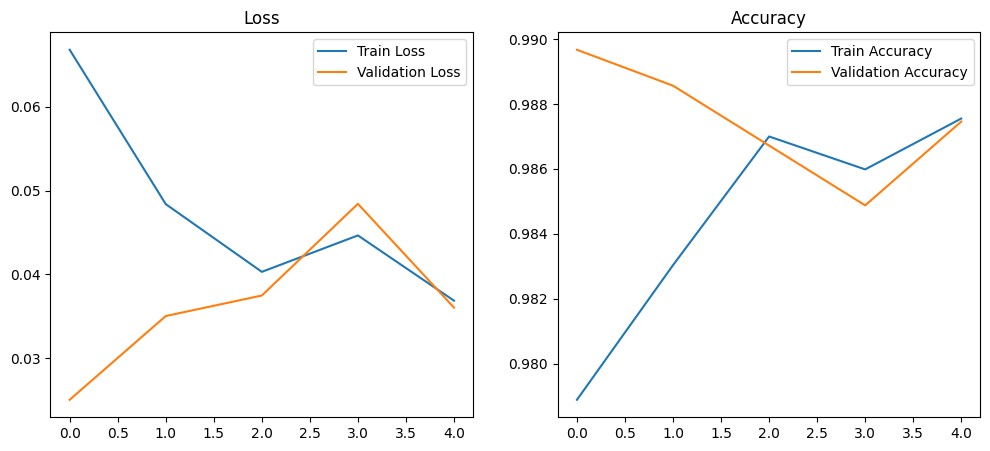

Execution took: 517.13 secs

===== Fold 4 =====
Train size: 10846, Val size: 2711
Started epoch: 0, using device:cuda 
Entering Validation Phase....


Premature end of JPEG file


[Warning] Unable to read image at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png. Skipping...
--------------------------------------------------
Epoch 1/5, Train Loss: 0.0485, Train Accuracy: 0.9841, Val Loss: 0.0221, Val Accuracy: 0.9919
For Class: 0, Train Recall: 0.9710, Train Precision: 0.9698, Train F1 Score is: 0.9704280495643616
For Class: 0, Val Recall: 1.0000, Val Precision: 0.9904, Val F1 Score is: 0.9951918125152588
For Class: 1, Train Recall: 0.9945, Train Precision: 0.9961, Train F1 Score is: 0.9953175783157349
For Class: 1, Val Recall: 1.0000, Val Precision: 1.0000, Val F1 Score is: 0.9999995231628418
For Class: 2, Train Recall: 0.9945, Train Precision: 0.9972, Train F1 Score is: 0.9958706498146057
For Class: 2, Val Recall: 1.0000, Val Precision: 0.9956, Val F1 Score is: 0.9978065490722656
For Class: 3, Train Recall: 0.9970, Train Precision: 0.9943, Train F1 Score is: 0.9956315159797668
For Class: 3, Val Recall: 0.9978,

Premature end of JPEG file


[Warning] Unable to read image at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png. Skipping...
--------------------------------------------------
Epoch 2/5, Train Loss: 0.0411, Train Accuracy: 0.9859, Val Loss: 0.0421, Val Accuracy: 0.9845
For Class: 0, Train Recall: 0.9843, Train Precision: 0.9819, Train F1 Score is: 0.9831116795539856
For Class: 0, Val Recall: 0.9807, Val Precision: 0.9854, Val F1 Score is: 0.9830503463745117
For Class: 1, Train Recall: 0.9928, Train Precision: 0.9967, Train F1 Score is: 0.994761049747467
For Class: 1, Val Recall: 0.9978, Val Precision: 0.9869, Val F1 Score is: 0.9923325181007385
For Class: 2, Train Recall: 0.9945, Train Precision: 0.9934, Train F1 Score is: 0.9939556121826172
For Class: 2, Val Recall: 0.9934, Val Precision: 0.9978, Val F1 Score is: 0.9955942630767822
For Class: 3, Train Recall: 0.9964, Train Precision: 0.9951, Train F1 Score is: 0.9957651495933533
For Class: 3, Val Recall: 0.9934, 

Premature end of JPEG file


[Warning] Unable to read image at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png. Skipping...
--------------------------------------------------
Epoch 3/5, Train Loss: 0.0272, Train Accuracy: 0.9903, Val Loss: 0.0220, Val Accuracy: 0.9915
For Class: 0, Train Recall: 0.9879, Train Precision: 0.9879, Train F1 Score is: 0.9879222512245178
For Class: 0, Val Recall: 1.0000, Val Precision: 0.9904, Val F1 Score is: 0.9951918125152588
For Class: 1, Train Recall: 0.9972, Train Precision: 0.9967, Train F1 Score is: 0.9969733357429504
For Class: 1, Val Recall: 1.0000, Val Precision: 1.0000, Val F1 Score is: 0.9999995231628418
For Class: 2, Train Recall: 0.9973, Train Precision: 0.9951, Train F1 Score is: 0.9961554408073425
For Class: 2, Val Recall: 1.0000, Val Precision: 1.0000, Val F1 Score is: 0.9999995231628418
For Class: 3, Train Recall: 0.9967, Train Precision: 0.9975, Train F1 Score is: 0.9971279501914978
For Class: 3, Val Recall: 1.0000,

Premature end of JPEG file


[Warning] Unable to read image at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png. Skipping...
--------------------------------------------------
Epoch 4/5, Train Loss: 0.0296, Train Accuracy: 0.9908, Val Loss: 0.0250, Val Accuracy: 0.9908
For Class: 0, Train Recall: 0.9855, Train Precision: 0.9831, Train F1 Score is: 0.98431795835495
For Class: 0, Val Recall: 0.9903, Val Precision: 0.9856, Val F1 Score is: 0.9879513382911682
For Class: 1, Train Recall: 0.9978, Train Precision: 0.9962, Train F1 Score is: 0.9969750642776489
For Class: 1, Val Recall: 1.0000, Val Precision: 0.9978, Val F1 Score is: 0.9988994002342224
For Class: 2, Train Recall: 0.9967, Train Precision: 0.9967, Train F1 Score is: 0.9967010021209717
For Class: 2, Val Recall: 0.9956, Val Precision: 1.0000, Val F1 Score is: 0.997796893119812
For Class: 3, Train Recall: 0.9964, Train Precision: 0.9995, Train F1 Score is: 0.9979460835456848
For Class: 3, Val Recall: 1.0000, Va

Premature end of JPEG file


[Warning] Unable to read image at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png. Skipping...
--------------------------------------------------
Epoch 5/5, Train Loss: 0.0313, Train Accuracy: 0.9908, Val Loss: 0.0301, Val Accuracy: 0.9889
For Class: 0, Train Recall: 0.9879, Train Precision: 0.9867, Train F1 Score is: 0.9873260259628296
For Class: 0, Val Recall: 0.9855, Val Precision: 0.9855, Val F1 Score is: 0.9855067729949951
For Class: 1, Train Recall: 0.9983, Train Precision: 0.9989, Train F1 Score is: 0.998623251914978
For Class: 1, Val Recall: 1.0000, Val Precision: 1.0000, Val F1 Score is: 0.9999995231628418
For Class: 2, Train Recall: 0.9956, Train Precision: 0.9945, Train F1 Score is: 0.9950544834136963
For Class: 2, Val Recall: 1.0000, Val Precision: 0.9978, Val F1 Score is: 0.9989018440246582
For Class: 3, Train Recall: 0.9973, Train Precision: 0.9978, Train F1 Score is: 0.9975384473800659
For Class: 3, Val Recall: 0.9989, 

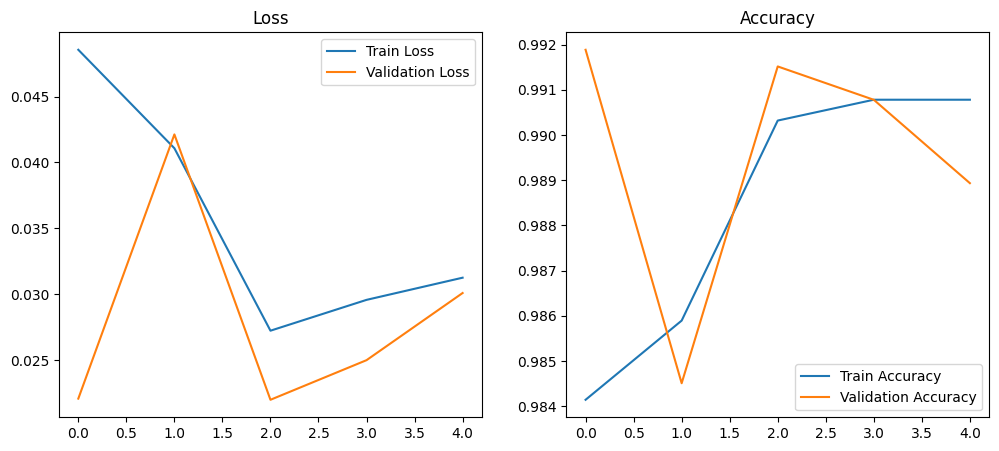

Execution took: 524.26 secs

===== Fold 5 =====
Train size: 10846, Val size: 2711
Started epoch: 0, using device:cuda 


Premature end of JPEG file


[Warning] Unable to read image at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png. Skipping...
Entering Validation Phase....
--------------------------------------------------
Epoch 1/5, Train Loss: 0.0484, Train Accuracy: 0.9840, Val Loss: 0.0209, Val Accuracy: 0.9937
For Class: 0, Train Recall: 0.9734, Train Precision: 0.9699, Train F1 Score is: 0.9716691970825195
For Class: 0, Val Recall: 0.9952, Val Precision: 0.9904, Val F1 Score is: 0.9927706122398376
For Class: 1, Train Recall: 0.9972, Train Precision: 0.9972, Train F1 Score is: 0.9972477555274963
For Class: 1, Val Recall: 0.9978, Val Precision: 0.9956, Val F1 Score is: 0.9966991543769836
For Class: 2, Train Recall: 0.9907, Train Precision: 0.9896, Train F1 Score is: 0.9901094436645508
For Class: 2, Val Recall: 0.9956, Val Precision: 0.9978, Val F1 Score is: 0.9966991543769836
For Class: 3, Train Recall: 0.9948, Train Precision: 0.9951, Train F1 Score is: 0.9949414134025574
For

Premature end of JPEG file


Entering Validation Phase....
--------------------------------------------------
Epoch 2/5, Train Loss: 0.0327, Train Accuracy: 0.9884, Val Loss: 0.0255, Val Accuracy: 0.9897
For Class: 0, Train Recall: 0.9903, Train Precision: 0.9844, Train F1 Score is: 0.9873565435409546
For Class: 0, Val Recall: 0.9952, Val Precision: 0.9717, Val F1 Score is: 0.9832931160926819
For Class: 1, Train Recall: 0.9950, Train Precision: 0.9961, Train F1 Score is: 0.9955942630767822
For Class: 1, Val Recall: 1.0000, Val Precision: 0.9956, Val F1 Score is: 0.9978017210960388
For Class: 2, Train Recall: 0.9934, Train Precision: 0.9945, Train F1 Score is: 0.9939489364624023
For Class: 2, Val Recall: 0.9890, Val Precision: 1.0000, Val F1 Score is: 0.9944746494293213
For Class: 3, Train Recall: 0.9959, Train Precision: 0.9959, Train F1 Score is: 0.9958989024162292
For Class: 3, Val Recall: 0.9989, Val Precision: 0.9978, Val F1 Score is: 0.9983592629432678
For Class: 4, Train Recall: 0.9896, Train Precision: 1.00

Premature end of JPEG file


Entering Validation Phase....
--------------------------------------------------
Epoch 3/5, Train Loss: 0.0315, Train Accuracy: 0.9887, Val Loss: 0.0171, Val Accuracy: 0.9937
For Class: 0, Train Recall: 0.9903, Train Precision: 0.9856, Train F1 Score is: 0.9879513382911682
For Class: 0, Val Recall: 0.9952, Val Precision: 0.9904, Val F1 Score is: 0.9927706122398376
For Class: 1, Train Recall: 0.9983, Train Precision: 0.9978, Train F1 Score is: 0.9980738162994385
For Class: 1, Val Recall: 1.0000, Val Precision: 1.0000, Val F1 Score is: 0.9999995231628418
For Class: 2, Train Recall: 0.9962, Train Precision: 0.9967, Train F1 Score is: 0.9964251518249512
For Class: 2, Val Recall: 0.9978, Val Precision: 1.0000, Val F1 Score is: 0.9988994002342224
For Class: 3, Train Recall: 0.9967, Train Precision: 0.9964, Train F1 Score is: 0.9965828657150269
For Class: 3, Val Recall: 1.0000, Val Precision: 0.9989, Val F1 Score is: 0.9994527697563171
For Class: 4, Train Recall: 0.9688, Train Precision: 0.98

Premature end of JPEG file


Entering Validation Phase....
--------------------------------------------------
Epoch 4/5, Train Loss: 0.0287, Train Accuracy: 0.9894, Val Loss: 0.0243, Val Accuracy: 0.9911
For Class: 0, Train Recall: 0.9903, Train Precision: 0.9868, Train F1 Score is: 0.9885468482971191
For Class: 0, Val Recall: 0.9952, Val Precision: 0.9810, Val F1 Score is: 0.9880091547966003
For Class: 1, Train Recall: 0.9961, Train Precision: 0.9967, Train F1 Score is: 0.996421217918396
For Class: 1, Val Recall: 1.0000, Val Precision: 0.9956, Val F1 Score is: 0.9978017210960388
For Class: 2, Train Recall: 0.9962, Train Precision: 0.9951, Train F1 Score is: 0.9956039190292358
For Class: 2, Val Recall: 0.9956, Val Precision: 1.0000, Val F1 Score is: 0.997796893119812
For Class: 3, Train Recall: 0.9956, Train Precision: 0.9962, Train F1 Score is: 0.9958978295326233
For Class: 3, Val Recall: 0.9978, Val Precision: 0.9989, Val F1 Score is: 0.9983574748039246
For Class: 4, Train Recall: 1.0000, Train Precision: 0.9796

Premature end of JPEG file


Entering Validation Phase....
--------------------------------------------------
Epoch 5/5, Train Loss: 0.0220, Train Accuracy: 0.9925, Val Loss: 0.0319, Val Accuracy: 0.9889
For Class: 0, Train Recall: 0.9928, Train Precision: 0.9964, Train F1 Score is: 0.994554877281189
For Class: 0, Val Recall: 0.9952, Val Precision: 0.9763, Val F1 Score is: 0.9856454730033875
For Class: 1, Train Recall: 0.9967, Train Precision: 0.9967, Train F1 Score is: 0.9966973662376404
For Class: 1, Val Recall: 1.0000, Val Precision: 1.0000, Val F1 Score is: 0.9999995231628418
For Class: 2, Train Recall: 0.9984, Train Precision: 0.9967, Train F1 Score is: 0.9975277185440063
For Class: 2, Val Recall: 1.0000, Val Precision: 0.9978, Val F1 Score is: 0.9989018440246582
For Class: 3, Train Recall: 0.9981, Train Precision: 0.9986, Train F1 Score is: 0.9983588457107544
For Class: 3, Val Recall: 0.9989, Val Precision: 0.9989, Val F1 Score is: 0.9989054203033447
For Class: 4, Train Recall: 0.9896, Train Precision: 0.989

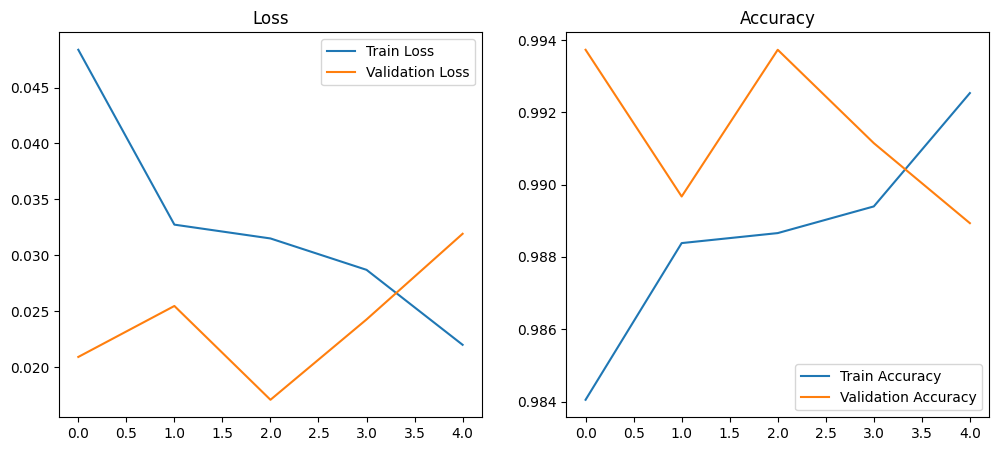

Execution took: 517.54 secs


In [21]:
train_with_val_graphs(Disaster_Dataset, idx_to_class)

In [ ]:
# your trained model
model.eval()

# dummy input (adjust shape to your model)
dummy_input = torch.randn(1, 3, 224, 224)

# export
torch.onnx.export(model, dummy_input, "model.onnx")